In [7]:
%pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn


  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 909.3 kB/s eta 0:00:12
   -- ------------------------------------- 0.8/11.0 MB 1.0 MB/s eta 0:00:11
   --- ------------------------------------ 1.0/11.0 MB 1.1 MB/s eta 0:00:10
   ---- ----------------------------------- 1.3/11.0 MB 1.1 MB/s eta 0:00:09
   ----- ---------------------------------- 1.6/11.0 MB 1.2 MB/s eta 0:00:08
   ------ --------------------------------- 1.8/11.0 MB 1.2 MB/s eta 0:00:08
   -------- ------------------------------- 2.4/11.0 MB 1.3 MB/s eta 0:00:07
   --------- ------------------------------ 2.6


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('city_day.csv')
print('Initial shape:', df.shape)
df.head()

Initial shape: (29531, 16)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [3]:
# Check unique city names
print(df['City'].unique())
# Map city names if needed
city_map = {
    'New Delhi': 'Delhi',
    'Bangalore': 'Bengaluru',
    'Kolkata': 'Kolkata',
    'Hyderabad': 'Hyderabad',
    'Jaipur': 'Jaipur',
    'Chennai': 'Chennai',
    'Visakhapatnam': 'Visakhapatnam'
}
selected_cities = list(city_map.values())
df_selected = df[df['City'].isin(selected_cities)].copy()
print('Shape after city filtering:', df_selected.shape)
df_selected['City'].value_counts()

['Ahmedabad' 'Aizawl' 'Amaravati' 'Amritsar' 'Bengaluru' 'Bhopal'
 'Brajrajnagar' 'Chandigarh' 'Chennai' 'Coimbatore' 'Delhi' 'Ernakulam'
 'Gurugram' 'Guwahati' 'Hyderabad' 'Jaipur' 'Jorapokhar' 'Kochi' 'Kolkata'
 'Lucknow' 'Mumbai' 'Patna' 'Shillong' 'Talcher' 'Thiruvananthapuram'
 'Visakhapatnam']
Shape after city filtering: (11423, 16)


City
Bengaluru        2009
Chennai          2009
Delhi            2009
Hyderabad        2006
Visakhapatnam    1462
Jaipur           1114
Kolkata           814
Name: count, dtype: int64

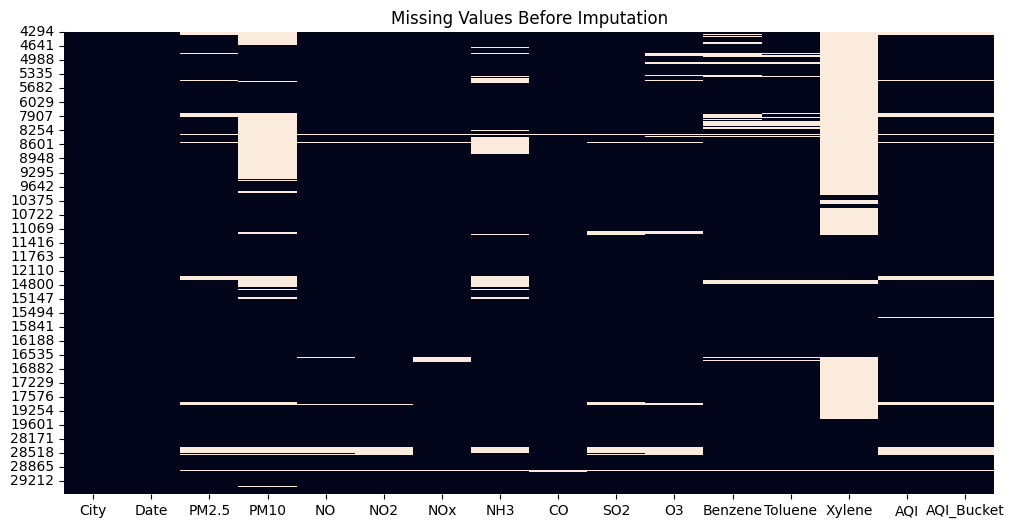

City             0
Date             0
PM2.5          677
PM10          2804
NO             340
NO2            359
NOx            198
NH3           1262
CO              87
SO2            479
O3             597
Benzene        739
Toluene        535
Xylene        6498
AQI            731
AQI_Bucket     731
dtype: int64


In [4]:
plt.figure(figsize=(12,6))
sns.heatmap(df_selected.isnull(), cbar=False)
plt.title('Missing Values Before Imputation')
plt.show()
print(df_selected.isnull().sum())

In [5]:
# Define a function to calculate AQI from pollutant values
def calculate_aqi_from_row(row):
    # Example breakpoints for PM2.5 and PM10 (adjust as per your standard)
    breakpoints = {
        'PM2.5': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400), (251, 500, 401, 500)],
        'PM10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400), (431, 600, 401, 500)],
        # Add more pollutants and their breakpoints as needed
    }
    def sub_index(value, pollutant):
        if pd.isna(value) or pollutant not in breakpoints:
            return None
        for bp in breakpoints[pollutant]:
            if bp[0] <= value <= bp[1]:
                return ((bp[3] - bp[2]) / (bp[1] - bp[0])) * (value - bp[0]) + bp[2]
        return None
    sub_indices = []
    for pollutant in ['PM2.5', 'PM10']:  # Add more pollutants as needed
        idx = sub_index(row[pollutant], pollutant)
        if idx is not None:
            sub_indices.append(idx)
    return max(sub_indices) if sub_indices else np.nan

In [6]:
num_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_selected.select_dtypes(include=['object']).columns.tolist()

# Impute numerical columns
num_cols = [col for col in df_selected.select_dtypes(include=[np.number]).columns if col != 'AQI']
num_imputer = SimpleImputer(strategy='median')
df_selected[num_cols] = num_imputer.fit_transform(df_selected[num_cols])

# For rows where AQI is missing, recalculate AQI from parameters
mask_missing_aqi = df_selected['AQI'].isna()
df_selected.loc[mask_missing_aqi, 'AQI'] = df_selected[mask_missing_aqi].apply(calculate_aqi_from_row, axis=1)

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df_selected[cat_cols] = cat_imputer.fit_transform(df_selected[cat_cols])

print('Shape after imputation:', df_selected.shape)
df_selected.isnull().sum()

Shape after imputation: (11423, 16)


City          0
Date          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
dtype: int64

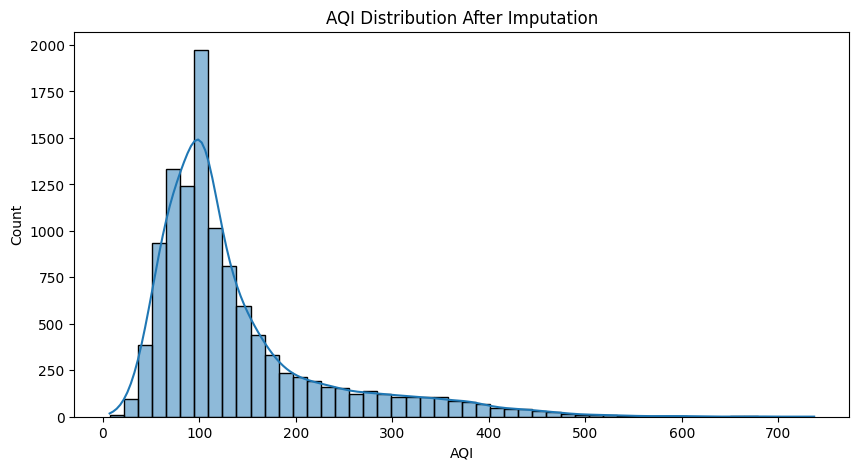

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(df_selected['AQI'], bins=50, kde=True)
plt.title('AQI Distribution After Imputation')
plt.show()

Class distribution:
AQI_Bucket
Moderate        5025
Satisfactory    3982
Poor            1045
Very Poor        640
Good             464
Severe           267
Name: count, dtype: int64


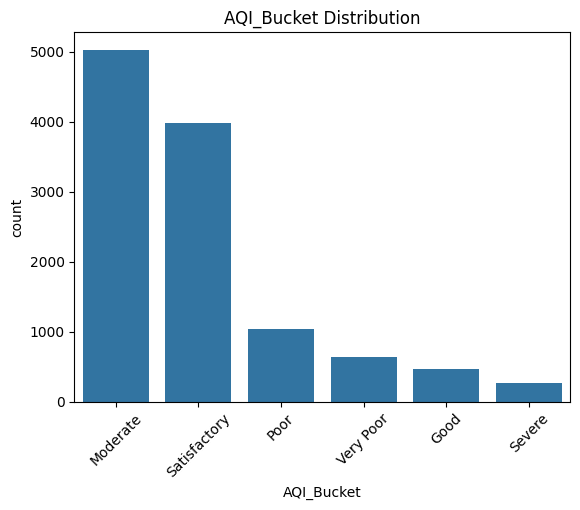

In [8]:
print('Class distribution:')
print(df_selected['AQI_Bucket'].value_counts())
sns.countplot(data=df_selected, x='AQI_Bucket', order=df_selected['AQI_Bucket'].value_counts().index)
plt.title('AQI_Bucket Distribution')
plt.xticks(rotation=45)
plt.show()

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_selected['AQI_Bucket_Code'] = le.fit_transform(df_selected['AQI_Bucket'])

X = df_selected.drop(['AQI_Bucket', 'AQI_Bucket_Code'], axis=1)
y = df_selected['AQI_Bucket_Code']

# For SMOTE, only use numeric columns
X_num = X.select_dtypes(include=[np.number])

print('Before SMOTE:', Counter(y))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_num, y)
print('After SMOTE:', Counter(y_res))

# Merge back with categorical columns for final dataset
df_res = pd.DataFrame(X_res, columns=X_num.columns)
df_res['AQI_Bucket_Code'] = y_res
df_res['AQI_Bucket'] = le.inverse_transform(y_res)

# Add back city and date columns
df_res['City'] = df_selected['City'].mode()[0]
df_res['Date'] = df_selected['Date'].mode()[0]
print('Shape after SMOTE:', df_res.shape)
df_res['AQI_Bucket'].value_counts()

Before SMOTE: Counter({1: 5025, 3: 3982, 2: 1045, 5: 640, 0: 464, 4: 267})
After SMOTE: Counter({1: 5025, 3: 5025, 2: 5025, 0: 5025, 5: 5025, 4: 5025})
Shape after SMOTE: (30150, 17)


AQI_Bucket
Moderate        5025
Satisfactory    5025
Poor            5025
Good            5025
Very Poor       5025
Severe          5025
Name: count, dtype: int64

In [10]:
df_res.to_csv('selected_cities_aqi_cleaned.csv', index=False)
print('Cleaned dataset saved as selected_cities_aqi_cleaned.csv')

Cleaned dataset saved as selected_cities_aqi_cleaned.csv
